In [1]:

from google.colab import drive
drive.mount('/gdrive')

import pandas as pd
import os
import numpy as np

import time
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    # np.mean(np.abs((y_true - y_pred)))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pd.option_context("display.max_rows", 100);
pd.option_context("display.max_columns", 100);
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)



os.chdir("/gdrive/My Drive/Colab Notebooks/dacon")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
train_raw = pd.read_csv("./data/comp_9th/fully_dropped.csv", parse_dates=['transacted_date','t_DateTime'], index_col=0)
train_raw['Time'] = pd.to_timedelta(train_raw['Time'])
train_raw['t_time_interval'] = pd.to_timedelta(train_raw['t_time_interval'])

train_raw['point'] = train_raw['installment_term'].apply(lambda x: True if x >= 60 else False )  
train_raw['is_installment'] = train_raw['installment_term'].apply(lambda x: False if (x == 60) or ( x == 0) else True)  

trDate_store = train_raw.groupby(['store_id'])['transacted_date'].agg(['max','min']).reset_index()

trDate_store['day_of_week'] = trDate_store['min'].dt.day_name()
starts_on_FRI = trDate_store[trDate_store['day_of_week'] == 'Friday']['store_id']
starts_on_FRI = starts_on_FRI.values

import gc
del trDate_store
gc.collect()




/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



97

In [0]:

trDate_store = train_raw.groupby(['store_id','transacted_date'])['amount','point','is_installment'].agg(['sum','count']).reset_index()
trDate_store.columns = ['store_id','transacted_date','sum_amt','cnt_amt','sum_pt','cnt_pt','sum_inst','cnt_inst']
trDate_store = trDate_store[['store_id','transacted_date','sum_amt','cnt_amt','sum_pt','sum_inst']]


In [0]:
d = [i.date() for i in pd.date_range('2016-06-01', '2019-02-28')]

temp = (trDate_store.groupby('store_id')['sum_amt']
      .apply(lambda x: x.reindex(d)  
                        .fillna(0)
                        )   
        .reset_index()
        .rename(columns={'level_1':'transacted_date',
                          'sum_amt':'none'}))
temp['transacted_date'] = pd.to_datetime(temp['transacted_date']) 
trDate_store = temp.merge(trDate_store, on=['store_id', 'transacted_date'], how='left')
# del temp
trDate_store = trDate_store.fillna(0)


In [0]:
holiday = pd.read_csv("./data/comp_9th/holiday.csv", parse_dates=['h_date'])
holiday_date = holiday['h_date'].values

trDate_store['is_holiday'] = trDate_store['transacted_date'].isin(holiday_date)
trDate_store = trDate_store.set_index('transacted_date')


In [0]:
trDate_store.drop('none',axis=1,inplace = True)
resampled = trDate_store.groupby(['store_id', pd.Grouper(freq='W-THU')]).sum().reset_index()
print(resampled.shape)
resampled.columns = ['store_id', 'transacted_date','amount', 'cnt', 'pt_cnt', 'inst_cnt', 'h-day_cnt' ]
add_info = trDate_store.groupby(['store_id', pd.Grouper(freq='W-THU')])['sum_amt'].agg(['mean','median']).reset_index()
resampled= resampled.merge(add_info, how='left', on=['store_id','transacted_date'])
print(resampled.shape)

resampled= resampled.rename(columns={'transacted_date': 'date'})

In [0]:
resampled.to_csv("./data/comp_9th/resmpled_before_rolling.csv", index=False)

In [0]:
resampled = pd.read_csv("./data/comp_9th/resmpled_before_rolling.csv", parse_dates=['date'])

In [0]:
rolling_days = [14, 21, 28, 56, 84] 

d = [i.date() for i in pd.date_range('2016-06-01', '2019-02-28')]

for r_days in rolling_days:
    resampled= resampled.set_index('date')
    week = int(r_days/7)
    temp = (resampled.groupby('store_id')['amount']
      .apply(lambda x: x.reindex(d)  
                        .fillna(0)   
                        .rolling(r_days)
                        .sum())
      .reset_index()
      .rename(columns={'amount': 'amount'  + '_sum_' +str(week)+'_weeks', 
                      'level_1': 'date'}))
    temp['date'] = pd.to_datetime(temp['date']) 
    resampled = resampled.reset_index() 
    resampled = resampled.merge(temp, on=['store_id', 'date'])
    del temp

resampled['amount_sum_2_weeks'] = resampled['amount_sum_2_weeks'] -  resampled['amount']
resampled['amount_sum_3_weeks'] = resampled['amount_sum_3_weeks'] -  resampled['amount_sum_2_weeks']
resampled['amount_sum_4_weeks'] = resampled['amount_sum_4_weeks'] -  resampled['amount_sum_3_weeks']
resampled['amount_sum_8_weeks'] = resampled['amount_sum_8_weeks'] -  resampled['amount_sum_4_weeks']
resampled['amount_sum_12_weeks'] = resampled['amount_sum_12_weeks'] -  resampled['amount_sum_8_weeks']

resampled = resampled.rename(
    columns={ 
        'amount_sum_2_weeks':'2nd_week_amt',
        'amount_sum_3_weeks':'3rd_week_amt',
        'amount_sum_4_weeks':'4th_week_amt',
        'amount_sum_8_weeks':'8th_til_4th_week_amt',
        'amount_sum_12_weeks':'12th_til_8th_week_amt'
    }
)



In [0]:
# rolling_days = [14, 21, 28, 56, 84 ,91] # 2주, 3주 ,4주, 8주, 12주 , 13주
rolling_days = [14 , 21, 28, 35, 42, 49, 56, 91] 
# rolling_days = [14, 28, 56, 91]

d = [i.date() for i in pd.date_range('2016-06-01', '2019-02-28')]

for r_days in rolling_days:
    resampled= resampled.set_index('date')
    week = int(r_days/7)
    temp = (resampled.groupby('store_id')['amount','median','mean','cnt','pt_cnt','inst_cnt','h-day_cnt']
      .apply(lambda x: x.reindex(d)
                        .fillna(0)   
                        .rolling(r_days)
                        .sum()) 
      .reset_index()
      .rename(columns={'amount': 'amount'  + '_sum_'+str(week)+'_weeks', 
                        'median': 'median' + '_sum_'+str(week)+'_weeks', 
                        'mean': 'mean'  + '_sum_'+str(week)+'_weeks', 
                        'cnt': 'cnt'  + '_sum_'+str(week)+'_weeks', 
                        'pt_cnt': 'pt_cnt'  + '_sum_'+str(week)+'_weeks', 
                        'inst_cnt': 'inst_cnt'  + '_sum_'+str(week)+'_weeks', 
                      'h-day_cnt': 'h-day_cnt'  + '_sum_'+str(week)+'_weeks', 
                      'level_1': 'date'}))
    temp['date'] = pd.to_datetime(temp['date']) 
    resampled = resampled.reset_index() 
    resampled = resampled.merge(temp, on=['store_id', 'date'])
    del temp

for r_days in rolling_days:
    resampled= resampled.set_index('date')
    week = int(r_days/7)
    temp = (resampled.groupby('store_id')['amount','median','mean','cnt','pt_cnt','inst_cnt','h-day_cnt']
      .apply(lambda x: x.reindex(d)
                        .fillna(0)  
                        .rolling(r_days)
                        .mean()) 
      .reset_index()
      .rename(columns={'amount': 'amount'  + '_mean_'+str(week)+'_weeks', 
                        'median': 'median' + '_mean_'+str(week)+'_weeks', 
                        'mean': 'mean'  + '_mean_'+str(week)+'_weeks', 
                        'cnt': 'cnt'  + '_mean_'+str(week)+'_weeks', 
                        'pt_cnt': 'pt_cnt'  + '_mean_'+str(week)+'_weeks', 
                        'inst_cnt': 'inst_cnt'  + '_mean_'+str(week)+'_weeks', 
                      'h-day_cnt': 'h-day_cnt'  + '_mean_'+str(week)+'_weeks', 
                      'level_1': 'date'}))
    temp['date'] = pd.to_datetime(temp['date']) 
    resampled = resampled.reset_index() 
    resampled = resampled.merge(temp, on=['store_id', 'date'])
    del temp



In [6]:
d = [i.date() for i in pd.date_range('2016-06-01','2019-02-28')]
d = d[::-1]
r_days = 92

resampled= resampled.set_index('date')
week = int(r_days/7)
temp = (resampled.iloc[::-1].groupby('store_id')['amount']
    .apply(lambda x: x.reindex(d)  
                      .fillna(0)   
                      .rolling(r_days)
                      .sum()
                      .iloc[::-1]) 
    .reset_index()
    .rename(columns={'amount': 'y' ,
                    'level_1': 'date'}))

temp['date'] = pd.to_datetime(temp['date']) 
resampled = resampled.reset_index() 
resampled = resampled.merge(temp, on=['store_id', 'date'])

resampled['y'] = resampled['y'] - resampled['amount']
del temp
print(resampled.shape)


(283248, 127)


In [7]:
resampled['time_interval'] = (resampled['date'] - resampled['date'].shift(1))

def remove_check(row):
    t =row['time_interval']
    if pd.isna(t):
        return True
    elif t > np.timedelta64(0,'D') :
        return False
    else:
        if row['store_id'] in starts_on_FRI:
            return False
        else:
            return True


resampled['to_remove'] = resampled.apply(remove_check , axis = 1)

print(resampled.shape)
resampled = resampled[~resampled['to_remove']]
print(resampled.shape)
# (254118, 68)
# (252336, 68)

(283248, 129)
(281466, 129)


In [8]:
from sklearn import preprocessing
bus_le = preprocessing.LabelEncoder()
hlr = preprocessing.LabelEncoder()
llr = preprocessing.LabelEncoder()

naive_store_info = train_raw.groupby('store_id')['region','type_of_business'].max().reset_index()

naive_store_info['summarized_bus'] = naive_store_info['type_of_business'].apply(lambda x: x.split()[-1] if pd.notna(x) else np.nan)
naive_store_info['type_bus'] =  naive_store_info['summarized_bus'].map(lambda x : bus_le.fit_transform([x])[0] if type(x) == str else x )

naive_store_info['h_level_region'] = naive_store_info['region'].apply(lambda x: x.split()[0] if pd.notna(x) else np.nan)

naive_store_info['high_region'] =  naive_store_info['h_level_region'].map(lambda x : hlr.fit_transform([x])[0] if type(x) == str else x )
naive_store_info['full_region'] = naive_store_info['region'].map(lambda x : llr.fit_transform([x])[0] if type(x) == str else x )

print(resampled.shape)
resampled = resampled.merge(naive_store_info[['store_id','type_bus','high_region', 'full_region']], on=['store_id'])
print(resampled.shape)


(281466, 129)
(281466, 132)


In [0]:
import re
def add_datepart(df, fldname, drop=True):
   
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(resampled, 'date' ,False)



In [0]:

resampled.drop(['time_interval','to_remove'],axis=1,inplace=True)

r_copy= resampled.copy()

In [12]:
resampled.head()

,date,store_id,amount,cnt,pt_cnt,inst_cnt,h-day_cnt,mean,median,2nd_week_amt,3rd_week_amt,4th_week_amt,8th_til_4th_week_amt,12th_til_8th_week_amt,amount_sum_2_weeks,median_sum_2_weeks,mean_sum_2_weeks,cnt_sum_2_weeks,pt_cnt_sum_2_weeks,inst_cnt_sum_2_weeks,h-day_cnt_sum_2_weeks,amount_sum_3_weeks,median_sum_3_weeks,mean_sum_3_weeks,cnt_sum_3_weeks,pt_cnt_sum_3_weeks,inst_cnt_sum_3_weeks,h-day_cnt_sum_3_weeks,amount_sum_4_weeks,median_sum_4_weeks,mean_sum_4_weeks,cnt_sum_4_weeks,pt_cnt_sum_4_weeks,inst_cnt_sum_4_weeks,h-day_cnt_sum_4_weeks,amount_sum_5_weeks,median_sum_5_weeks,mean_sum_5_weeks,cnt_sum_5_weeks,pt_cnt_sum_5_weeks,...,h-day_cnt_mean_5_weeks,amount_mean_6_weeks,median_mean_6_weeks,mean_mean_6_weeks,cnt_mean_6_weeks,pt_cnt_mean_6_weeks,inst_cnt_mean_6_weeks,h-day_cnt_mean_6_weeks,amount_mean_7_weeks,median_mean_7_weeks,mean_mean_7_weeks,cnt_mean_7_weeks,pt_cnt_mean_7_weeks,inst_cnt_mean_7_weeks,h-day_cnt_mean_7_weeks,amount_mean_8_weeks,median_mean_8_weeks,mean_mean_8_weeks,cnt_mean_8_weeks,pt_cnt_mean_8_weeks,inst_cnt_mean_8_weeks,h-day_cnt_mean_8_weeks,amount_mean_13_weeks,median_mean_13_weeks,mean_mean_13_weeks,cnt_mean_13_weeks,pt_cnt_mean_13_weeks,inst_cnt_mean_13_weeks,h-day_cnt_mean_13_weeks,y,type_bus,high_region,full_region,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear
0,2016-06-09,0,112571.428571,26.0,0.0,0.0,1.0,16081.632653,17285.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.724714e+06,0.0,NaN,NaN,2016,6,23,9,3,161,23
1,2016-06-16,0,254285.714286,36.0,0.0,2.0,0.0,36326.530612,48714.285714,112571.428571,NaN,NaN,NaN,NaN,366857.142857,66000.000000,52408.163265,62.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.695143e+06,0.0,NaN,NaN,2016,6,24,16,3,168,24
2,2016-06-23,0,145857.142857,34.0,0.0,2.0,0.0,20836.734694,20000.000000,254285.714286,258428.571429,NaN,NaN,NaN,400142.857143,68714.285714,57163.265306,70.0,0.0,4.0,0.0,512714.285714,86000.000000,73244.897959,96.0,0.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.698000e+06,0.0,NaN,NaN,2016,6,25,23,3,175,25
3,2016-06-30,0,181142.857143,36.0,0.0,0.0,0.0,25877.551020,23428.571429,145857.142857,435428.571429,258428.571429,NaN,NaN,327000.000000,43428.571429,46714.285714,70.0,0.0,2.0,0.0,581285.714286,92142.857143,83040.816327,106.0,0.0,4.0,0.0,693857.142857,109428.571429,99122.448980,132.0,0.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.739429e+06,0.0,NaN,NaN,2016,6,26,30,3,182,26
4,2016-07-07,0,232285.714286,42.0,0.0,3.0,0.0,33183.673469,36714.285714,181142.857143,378142.857143,435428.571429,NaN,NaN,413428.571429,60142.857143,59061.224490,78.0,0.0,3.0,0.0,559285.714286,80142.857143,79897.959184,112.0,0.0,5.0,0.0,813571.428571,128857.142857,116224.489796,148.0,0.0,7.0,0.0,926142.857143,146142.857143,132306.122449,174.0,0.0,...,0.028571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.677571e+06,0.0,NaN,NaN,2016,7,27,7,3,189,27


In [0]:
resampled.to_csv("./data/comp_9th/resampled_for0s_featmany.csv",index=False)

In [0]:
resampled = pd.read_csv("./data/comp_9th/resampled_for0s_featmany.csv",parse_dates=['date'])

In [0]:
# cand_test = resampled[resampled['date'] >= pd.to_datetime('2018-11-28') ]

real_train = resampled[resampled['date'] <= pd.to_datetime('2018-11-30') ]

real_test = resampled[(resampled['Year'] == 2019) &
                      (resampled['Month'] == 2) &
                      (resampled['Day'] == 28) ]

In [0]:
original_target = real_train.y.values
target, lambda_prophet = stats.boxcox(real_train['y'] + 1)
len_train=target.shape[0]
merged_df = pd.concat([real_train, real_test])

merged_df.drop(['y','date'],axis=1,inplace=True)

cate = ['store_id', 
        'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'weekofyear','type_bus', 'high_region', 'full_region']

columns = merged_df.columns.values
col_dict = {}
for i,colname in enumerate(columns):
    col_dict[colname] = i
cate_feat2num = [col_dict[colname] for colname in cate]


In [30]:
params = {
    'nthread': 4,
    'categorical_feature' : cate_feat2num, # Day, DayOfWeek, Month, Week, Item, Store, WeekOfYear
    'max_depth': 10,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'num_leaves': 1023,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 30,
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1
}


# do the training
num_folds = 3
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target # removing what we did earlier

oof_preds = np.zeros([all_y.shape[0]])
sub_preds = np.zeros([test_x.shape[0]])

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=num_folds, shuffle=True, random_state=345665)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
  
    train_x, train_y = all_x[train_idx], all_y[train_idx]
    valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
        
    # train
    gbm = lgb.train(params, lgb_train, 4000, 
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100, verbose_eval=100)
    
    oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
    sub_preds[:] += gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
    valid_idx += 1
    importance_df = pd.DataFrame()
    importance_df['feature'] = merged_df.columns
    importance_df['importance'] = gbm.feature_importance()
    importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, importance_df], axis=0)
    
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score With Box Cox %.4f' %e)
print('Inverting Box Cox Transformation')
print('Done!!')

sub_preds = inverse_boxcox(sub_preds , lambda_prophet) - 1
oof_preds = inverse_boxcox(oof_preds , lambda_prophet) - 1
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score Re-Box Cox Transformation is %.4f' %e)



/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.



Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 1.94026	valid_1's mape: 2.1189
[200]	training's mape: 1.60195	valid_1's mape: 1.82277
[300]	training's mape: 1.48596	valid_1's mape: 1.74989
[400]	training's mape: 1.41114	valid_1's mape: 1.6998
[500]	training's mape: 1.3575	valid_1's mape: 1.66702
[600]	training's mape: 1.32435	valid_1's mape: 1.65156
[700]	training's mape: 1.28881	valid_1's mape: 1.63531
[800]	training's mape: 1.26505	valid_1's mape: 1.62698
[900]	training's mape: 1.23752	valid_1's mape: 1.61254
[1000]	training's mape: 1.21796	valid_1's mape: 1.60603
[1100]	training's mape: 1.19857	valid_1's mape: 1.59929
[1200]	training's mape: 1.1873	valid_1's mape: 1.59759
[1300]	training's mape: 1.16726	valid_1's mape: 1.59028
[1400]	training's mape: 1.1503	valid_1's mape: 1.58401
[1500]	training's mape: 1.1333	valid_1's mape: 1.57824
[1600]	training's mape: 1.12146	valid_1's mape: 1.57398
[1700]	training's mape: 1.11107	valid_1's mape: 1.57029


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning:

invalid value encountered in log



In [0]:
# /usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning:

# categorical_feature keyword has been found in `params` and will be ignored.
# Please use categorical_feature argument of the Dataset constructor to pass this parameter.

# Training until validation scores don't improve for 100 rounds.
# [100]	training's mape: 1.94026	valid_1's mape: 2.1189
# [200]	training's mape: 1.60195	valid_1's mape: 1.82277
# [300]	training's mape: 1.48596	valid_1's mape: 1.74989
# [400]	training's mape: 1.41114	valid_1's mape: 1.6998
# [500]	training's mape: 1.3575	valid_1's mape: 1.66702
# [600]	training's mape: 1.32435	valid_1's mape: 1.65156
# [700]	training's mape: 1.28881	valid_1's mape: 1.63531
# [800]	training's mape: 1.26505	valid_1's mape: 1.62698
# [900]	training's mape: 1.23752	valid_1's mape: 1.61254
# [1000]	training's mape: 1.21796	valid_1's mape: 1.60603
# [1100]	training's mape: 1.19857	valid_1's mape: 1.59929
# [1200]	training's mape: 1.1873	valid_1's mape: 1.59759
# [1300]	training's mape: 1.16726	valid_1's mape: 1.59028
# [1400]	training's mape: 1.1503	valid_1's mape: 1.58401
# [1500]	training's mape: 1.1333	valid_1's mape: 1.57824
# [1600]	training's mape: 1.12146	valid_1's mape: 1.57398
# [1700]	training's mape: 1.11107	valid_1's mape: 1.57029
# [1800]	training's mape: 1.09623	valid_1's mape: 1.56337
# [1900]	training's mape: 1.08606	valid_1's mape: 1.56017
# [2000]	training's mape: 1.07717	valid_1's mape: 1.5582
# [2100]	training's mape: 1.06618	valid_1's mape: 1.55347
# [2200]	training's mape: 1.05488	valid_1's mape: 1.54967
# [2300]	training's mape: 1.04126	valid_1's mape: 1.54161
# [2400]	training's mape: 1.0328	valid_1's mape: 1.53898
# [2500]	training's mape: 1.02548	valid_1's mape: 1.53626
# [2600]	training's mape: 1.01426	valid_1's mape: 1.53068
# [2700]	training's mape: 1.00809	valid_1's mape: 1.53004
# [2800]	training's mape: 1.00133	valid_1's mape: 1.52792
# [2900]	training's mape: 0.994152	valid_1's mape: 1.52527
# [3000]	training's mape: 0.989721	valid_1's mape: 1.52397
# [3100]	training's mape: 0.984295	valid_1's mape: 1.52214
# [3200]	training's mape: 0.978443	valid_1's mape: 1.5197
# [3300]	training's mape: 0.971458	valid_1's mape: 1.51668
# [3400]	training's mape: 0.96564	valid_1's mape: 1.51487
# [3500]	training's mape: 0.95995	valid_1's mape: 1.51302
# [3600]	training's mape: 0.953894	valid_1's mape: 1.51107
# [3700]	training's mape: 0.948686	valid_1's mape: 1.5102
# [3800]	training's mape: 0.942888	valid_1's mape: 1.50826
# [3900]	training's mape: 0.9384	valid_1's mape: 1.50753
# [4000]	training's mape: 0.934666	valid_1's mape: 1.50642
# Did not meet early stopping. Best iteration is:
# [4000]	training's mape: 0.934666	valid_1's mape: 1.50642
# Training until validation scores don't improve for 100 rounds.
# [100]	training's mape: 1.96766	valid_1's mape: 2.20437
# [200]	training's mape: 1.63481	valid_1's mape: 1.91447
# [300]	training's mape: 1.53329	valid_1's mape: 1.8514
# [400]	training's mape: 1.47659	valid_1's mape: 1.82895
# [500]	training's mape: 1.43361	valid_1's mape: 1.81317
# [600]	training's mape: 1.39734	valid_1's mape: 1.80006
# [700]	training's mape: 1.36216	valid_1's mape: 1.78536
# [800]	training's mape: 1.337	valid_1's mape: 1.77782
# [900]	training's mape: 1.31619	valid_1's mape: 1.77173
# [1000]	training's mape: 1.29229	valid_1's mape: 1.76014
# [1100]	training's mape: 1.27308	valid_1's mape: 1.75394
# [1200]	training's mape: 1.25053	valid_1's mape: 1.74236
# [1300]	training's mape: 1.2354	valid_1's mape: 1.73892
# [1400]	training's mape: 1.22021	valid_1's mape: 1.73392
# [1500]	training's mape: 1.20171	valid_1's mape: 1.72659
# [1600]	training's mape: 1.19108	valid_1's mape: 1.72421
# [1700]	training's mape: 1.17738	valid_1's mape: 1.71956
# [1800]	training's mape: 1.16648	valid_1's mape: 1.71583
# [1900]	training's mape: 1.1586	valid_1's mape: 1.71438
# [2000]	training's mape: 1.14289	valid_1's mape: 1.70549
# [2100]	training's mape: 1.13468	valid_1's mape: 1.70361
# [2200]	training's mape: 1.12741	valid_1's mape: 1.7021
# Early stopping, best iteration is:
# [2196]	training's mape: 1.12751	valid_1's mape: 1.70177
# Training until validation scores don't improve for 100 rounds.
# [100]	training's mape: 1.90072	valid_1's mape: 2.02457
# [200]	training's mape: 1.59053	valid_1's mape: 1.75951
# [300]	training's mape: 1.46869	valid_1's mape: 1.68063
# [400]	training's mape: 1.40823	valid_1's mape: 1.65763
# [500]	training's mape: 1.37006	valid_1's mape: 1.64617
# [600]	training's mape: 1.33897	valid_1's mape: 1.63647
# [700]	training's mape: 1.30189	valid_1's mape: 1.62082
# [800]	training's mape: 1.27785	valid_1's mape: 1.61273
# [900]	training's mape: 1.25324	valid_1's mape: 1.6042
# [1000]	training's mape: 1.23621	valid_1's mape: 1.60053
# [1100]	training's mape: 1.21699	valid_1's mape: 1.59544
# [1200]	training's mape: 1.19968	valid_1's mape: 1.58948
# [1300]	training's mape: 1.17948	valid_1's mape: 1.5825
# [1400]	training's mape: 1.16861	valid_1's mape: 1.58156
# [1500]	training's mape: 1.15491	valid_1's mape: 1.57747
# [1600]	training's mape: 1.14029	valid_1's mape: 1.57164
# [1700]	training's mape: 1.12574	valid_1's mape: 1.56582
# [1800]	training's mape: 1.11637	valid_1's mape: 1.56357
# [1900]	training's mape: 1.10661	valid_1's mape: 1.56035
# [2000]	training's mape: 1.09666	valid_1's mape: 1.55647
# [2100]	training's mape: 1.09091	valid_1's mape: 1.55611
# Early stopping, best iteration is:
# [2061]	training's mape: 1.09218	valid_1's mape: 1.55496
# Full validation score With Box Cox 0.1576
# Inverting Box Cox Transformation
# Done!!
# Full validation score Re-Box Cox Transformation is nan
# /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning:

# invalid value encountered in log

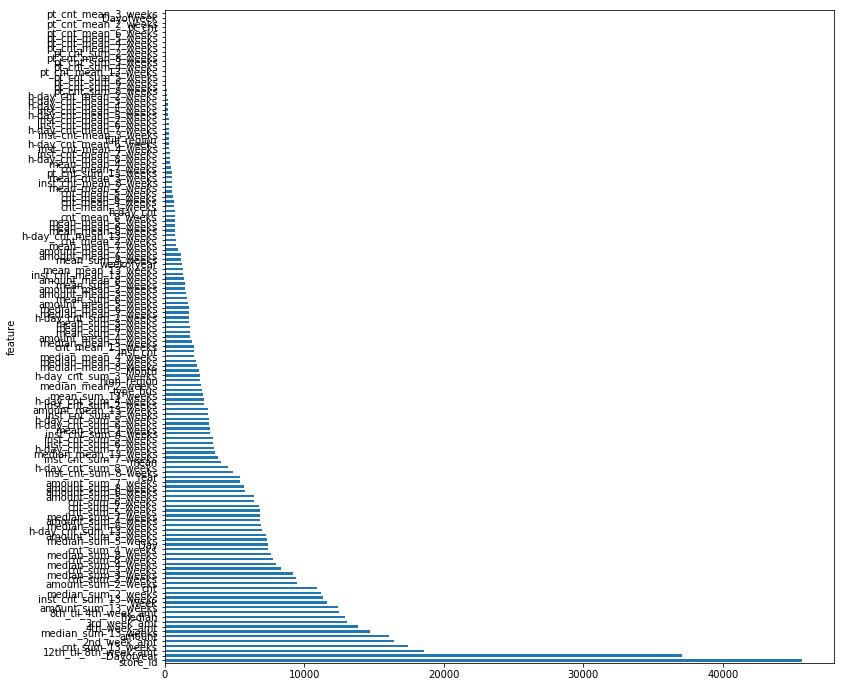

In [32]:
importance_df.sort_values(['importance'], ascending=False, inplace=True);

def plot_fi(fi): 
    return fi.plot('feature', 'importance', 'barh', figsize=(12,12), legend=False)

plot_fi(importance_df[:]);

In [0]:
submission_store_id = real_test['store_id'].values

predicted = pd.DataFrame(
    {'store_id': submission_store_id,
     'pred': sub_preds
    }
)

sub = pd.read_csv("./data/comp_9th/submission.csv")
temp = sub.merge(predicted,how='left',on='store_id')
temp = temp[['store_id','pred']]
temp = temp.rename(columns={'pred':'amount'})



In [0]:
temp.to_csv('./submission_0806_03.csv', index = False)

- ref: 
    - https://machinelearningmastery.com/multi-step-time-series-forecasting/
    - https://www.kaggle.com/adityaecdrid/my-first-time-series-comp-added-prophet
    - https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    - https://www.kaggle.com/slivka83/eda-futures-lightgbm-catboost#4.-Model
